<a href="https://colab.research.google.com/github/HHL43/Generative-AI-HW/blob/main/AI_final_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AI 說書人
## 使用的模型
本專案採用 Groq 平台提供的 LLaMA 3 70B 8192 模型作為生成式語言模型，負責根據使用者輸入的主題產生150字左右的英文兒童短篇故事。LLaMA 3 是 Meta 開源的高效大型語言模型，能夠理解語境並生成流暢自然的文字。

在文字轉語音（TTS）部分，使用了由 Kokoro 提供的 KPipeline 語音合成模組，搭配多種語音聲線（如 af_heart）將生成的故事轉換成高品質語音，達到聽覺上的互動體驗。

## 想達成的目的
本專案目標是打造一個簡易的互動式平台，讓使用者只需輸入主題，系統即可即時產生適合兒童的英文短篇故事，並能即時合成語音朗讀。除此之外，使用者還可以自由編輯故事內容，再按下「生成語音」按鈕聆聽修改後的版本，增加靈活度與互動性。
此平台期望為教學、親子共讀或語言學習提供輔助工具，降低創作門檻並提升使用樂趣。

## 專案重點
輸入主題 → 生成故事：

使用者在「輸入主題」欄位填入關鍵字，如「一隻會說話的章魚」，點擊「生成故事」按鈕，系統調用 LLaMA 3 模型，返回一段約150字的英文故事。


編輯故事內容：

生成的故事顯示於可編輯文字框中，使用者可以自行修改內容，調整故事細節與文字風格。


生成語音 → 播放：

修改完成後，點擊「生成語音」按鈕，系統使用 Kokoro 的 TTS pipeline，將故事文字轉為語音，並在介面播放。


技術調整與引導流程：

透過分離「生成故事」和「生成語音」兩個按鈕，實現文字編輯自由度。

使用 Gradio 的 Blocks 和 Row 元件調整介面排版與按鈕樣式，使操作簡單直覺。

融合 Groq LLaMA 3 API 與 Kokoro TTS，達成端到端生成與語音合成。

## 最終成果
完成一個介面簡潔、使用直觀的網頁應用，結合大型語言模型和多語音合成功能，達成：

輸入主題即生成英文短篇故事。

使用者可即時編輯故事內容。

按下按鈕即可生成並播放對應故事的自然語音。

適用於語言教學、親子共讀等場景。

此專案展示生成式 AI 在多媒體應用的可能性，也為未來加入更多互動與多語言支援奠定基礎。

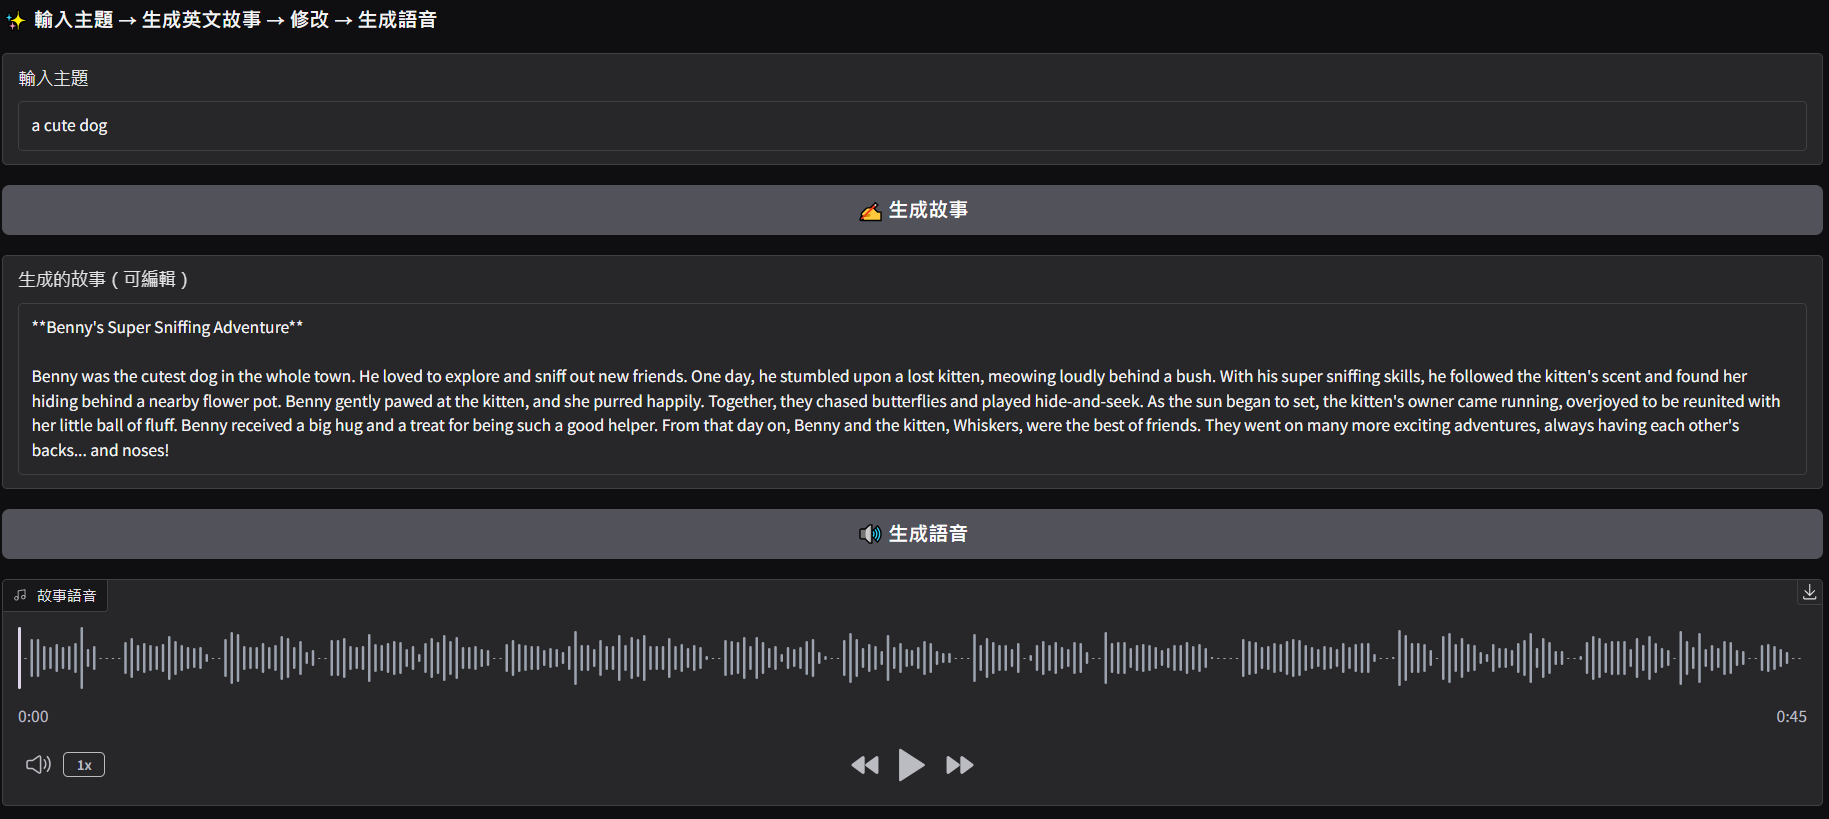

In [1]:
!pip install -q kokoro>=0.9.4 soundfile
!apt-get -qq -y install espeak-ng > /dev/null 2>&1
!pip install ordered_set pypinyin cn2an gradio openai
from kokoro import KPipeline
from IPython.display import display, Audio
import soundfile as sf
import torch
import os
import gradio as gr
from google.colab import userdata
from openai import OpenAI
import numpy as np

In [2]:
api_key = userdata.get('Groq')
os.environ['OPENAI_API_KEY'] = api_key

client = OpenAI(base_url="https://api.groq.com/openai/v1")
model = "llama3-70b-8192"

In [3]:
pipeline = KPipeline(lang_code='a')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torch/nn/utils/weight_norm.py:143: FutureWarning: `torch.nn.utils.weight_norm` is deprecated in favor of `torch.nn.utils.parametrizations.weight_norm`.
  WeightNorm.apply(module, name, di

In [4]:
def synthesize_audio(text, output_path="output.wav"):
    generator = pipeline(
        text,
        voice='af_heart',   # 你可以改成 'en_ryan' 等其他語音
        speed=1,
        split_pattern=r'\n+'   # 將故事段落分句合成
    )

    all_audio = [audio for _, _, audio in generator]

    if all_audio:
        merged = np.concatenate(all_audio)
        sf.write(output_path, merged, 24000)
        return output_path

    return None

In [5]:
# ✅ 故事生成
def generate_story(prompt):
    response = client.chat.completions.create(
        model=model,
        messages=[
            {"role": "system", "content": "你是一位擅長為兒童寫短篇故事的作家。"},
            {"role": "user", "content": f"請用以下主題寫一段 150 字的有趣故事：{prompt}"}
        ],
        temperature=0.8
    )
    return response.choices[0].message.content

In [6]:
def generate_and_speak(prompt):
    story = generate_story(prompt)
    audio_path = synthesize_audio(story)
    return story, audio_path

In [7]:
with gr.Blocks(title="📚 AI 說書人") as demo:
    gr.Markdown("### ✨ 輸入主題 → 生成英文故事 → 修改 → 生成語音")


    theme_input = gr.Textbox(label="輸入主題", placeholder="例如：一隻會說話的章魚")
    generate_btn = gr.Button("✍️ 生成故事")

    story_text = gr.Textbox(label="生成的故事（可編輯）", lines=6)
    gen_audio_btn = gr.Button("🔊 生成語音")
    audio_output = gr.Audio(label="故事語音", type="filepath")

    # 按下生成故事按鈕
    generate_btn.click(
        fn=generate_story,
        inputs=theme_input,
        outputs=story_text
    )

    # 按下生成語音按鈕
    gen_audio_btn.click(
        fn=synthesize_audio,
        inputs=story_text,
        outputs=audio_output
    )

demo.launch(debug=True)

It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
* Running on public URL: https://fc36c00af7a5933c4f.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7860 <> https://fc36c00af7a5933c4f.gradio.live
